## Sample QC and population definition
#### Yosuke Tanigawa (ytanigaw@stanford.edu)
#### 2019/8/4


- We used a combination of PCA (on array genotype data) and self-reported ancestry to define the following five population groups
  - White British (`ukb24983_white_british.phe`, N = 337151)
  - Non-British White (`ukb24983_non_british_white.phe`, N = 24909)
  - African (`ukb24983_african.phe`, N = 7214)
  - South Asian (`ukb24983_s_asian.phe`, N = 9084)
  - East Asian (`ukb24983_e_asian.phe`, N = 2356)
  - In total, we have 380,714 unrelated individuals
- Those files are available: `/oak/stanford/groups/mrivas/ukbb24983/sqc/population_stratification_w24983_20190804`
- Sample QC criteria
    - Our filtering criteria are as follows:
        - `! in_remove_file`
        - `FID >= 0`
        - `IID >= 0`    
        - `putative_sex_chromosome_aneuploidy == 0`
        - `het_missing_outliers == 0`
        - `excess_relatives == 0`
        - `used_in_pca_calculation == 1`
    - where, 
        - we removed individuals in our "remove file" and individuals with negative FID/IID
        - the remove file is `/oak/stanford/groups/mrivas/ukbb24983/sqc/w24983_20181016.csv`
        - used four fields in sample QC file (sqc file)
- We defined the following thresholds to define ethnic groups
  - White British
      - `-20 <= PC1 <= 40 && -25 <= PC2 <= 10`
      - `in_white_British_ancestry_subset == 1` (in sample QC file)
  - Non-British White
      - `-20 <= PC1 <= 40 && -25 <= PC2 <= 10`
      - Based on self-reported ancestry (UKB field 21000), the individual is White, but is not White British.
  - African
      - `PC1>= 260  && PC2 >= 50`
  - South Asian
      - `-170 <= PC2 <= -80`
  - East Asian
      - `PC2 <= -230`


In [1]:
suppressMessages(require(tidyverse))
suppressMessages(require(data.table))

In [2]:
read_sqc <- function(){
    # This function reads sample QC (sqc) file
    sqc_dir <- '/oak/stanford/groups/mrivas/ukbb24983/sqc/download'
    sqc_cols <- file.path(sqc_dir, 'ukb_sqc_v2.fields.txt') %>% 
    fread(header=F, data.table=F, col.names = 'col') %>% 
    filter(col != '') %>% pull()

    file.path(sqc_dir, 'ukb_sqc_v2.txt') %>% 
    fread(header=F, data.table=F, col.names = sqc_cols)
}

In [3]:
read_fam <- function(){
    # This function reads PLINK fam file
    '/oak/stanford/groups/mrivas/ukbb24983/fam/ukb2498_cal_v2_s488370.fam' %>%
    fread(
        header=F, data.table=F, 
        col.names = c('FID', 'IID', 'father', 'mother', 'sex_code', 'batch')
    ) %>%
    left_join(
        data.frame(
            sex_code = c(1, 2, 0),
            sex = c('male', 'female', 'unknown')
        ),
        by='sex_code'
    )    
}

In [4]:
read_remove <- function(){
    # read list of individuals that should be removed from the analysis
    '/oak/stanford/groups/mrivas/ukbb24983/sqc/w24983_20181016.csv' %>%
    fread(header=F, data.table=F, col.names=c('FID')) %>%
    mutate(IID=FID, in_remove_file=TRUE)    
}

In [5]:
read_self_reported_ethnicity <- function(){
    paste0(
        'cat ',
        '/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/extras/self_reported_ethnicity/phe/ukb9796_ukb24611_f21000.phe',
        ' | sed -e "s/^#//g"'
    ) %>%
    fread(cmd=., header=T, data.table=F)
}


In [6]:
read_coding1001 <- function(){
    df <- '/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/extras/self_reported_ethnicity/misc/coding1001.tsv' %>%
    fread(header=T, data.table=F, sep='\t')    
    
    df %>%
    mutate(parent_id = if_else(parent_id == 0, coding, parent_id)) %>%
    left_join(
        df %>% select(coding, meaning) %>% rename(
            parent_id = coding, parent_label = meaning
        ),
        by='parent_id'
    ) %>% select(-node_id, -selectable, -parent_id) %>%
    rename(
        coding1001 = coding,
        top_label = parent_label,
        sub_label = meaning
    )    
}

In [7]:
read_self_reported_ethnicity_all <- function(){
    '/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/extras/self_reported_ethnicity/misc/ukb9796_ukb24611_f21000.tsv' %>%
    fread(header=T, data.table=F) %>%
    rename(
        f21000_0 = '21000.0.0',
        f21000_1 = '21000.1.0',
        f21000_2 = '21000.2.0'    
    )
}


In [8]:
read_master_sqc <- function(){
    fam_df <- read_fam()
    sqc_df <- read_sqc()
    remove_df <- read_remove()
    self_reported_ethnicity <- read_self_reported_ethnicity()
    coding1001 <- read_coding1001()
    self_reported_ethnicity_all <- read_self_reported_ethnicity_all()
    
    bind_cols(fam_df, sqc_df) %>%
    left_join(remove_df, by=c('FID', 'IID')) %>%
    left_join(self_reported_ethnicity, by=c('FID', 'IID')) %>%
    left_join(coding1001 %>% rename(f21000 = coding1001), by='f21000') %>%
    left_join(self_reported_ethnicity_all, by='IID') %>%    
    replace_na(list(in_remove_file=F)) %>%
    mutate(
        pass_QC_filter = (
            (putative_sex_chromosome_aneuploidy == 0) &
            (het_missing_outliers == 0) & 
            (excess_relatives == 0) & 
            (FID >= 0) &
            (IID >= 0) &
            (! in_remove_file) 
        ),
        pass_filter = (
            pass_QC_filter &
            (used_in_pca_calculation == 1)
        ),        
        l_self_reported_NBW = if_else(
            (is.na(f21000_0) | (f21000_0 %in% c(1, 1002, 1003))) &
            (is.na(f21000_1) | (f21000_1 %in% c(1, 1002, 1003))) &
            (is.na(f21000_2) | (f21000_2 %in% c(1, 1002, 1003))) &
            (! (is.na(f21000_0) & is.na(f21000_1) & is.na(f21000_2))),            
            T, F
        )        
    )    
}

In [9]:
master_sqc_df <- read_master_sqc()

In [10]:
master_sqc_df %>% colnames()

[1] "FID"                                "IID"                               
 [3] "father"                             "mother"                            
 [5] "sex_code"                           "batch"                             
 [7] "sex"                                "affymetrix_field_1"                
 [9] "affymetrix_field_2"                 "genotyping_array"                  
[11] "Batch"                              "Plate_Name"                        
[13] "Well"                               "Cluster_CR"                        
[15] "dQC"                                "Internal_Pico_ng_uL"               
[17] "Submitted_Gender"                   "Inferred_Gender"                   
[19] "X_intensity"                        "Y_intensity"                       
[21] "Submitted_Plate_Name"               "Submitted_Well"                    
[23] "sample_qc_missing_rate"             "heterozygosity"                    
[25] "heterozygosity_pc_corrected"        "het_missing_outliers"              
[27] "putative_sex_chromosome_aneuploidy" "in_kinship_table"                  
[29] "excluded_from_kinship_inference"    "excess_relatives"                  
[31] "in_white_British_ancestry_subset"   "used_in_pca_calculation"           
[33] "PC1"                                "PC2"                               
[35] "PC3"                                "PC4"                               
[37] "PC5"                                "PC6"                               
[39] "PC7"                                "PC8"                               
[41] "PC9"                                "PC10"                              
[43] "PC11"                               "PC12"                              
[45] "PC13"                               "PC14"                              
[47] "PC15"                               "PC16"                              
[49] "PC17"                               "PC18"                              
[51] "PC19"                               "PC20"                              
[53] "PC21"                               "PC22"                              
[55] "PC23"                               "PC24"                              
[57] "PC25"                               "PC26"                              
[59] "PC27"                               "PC28"                              
[61] "PC29"                               "PC30"                              
[63] "PC31"                               "PC32"                              
[65] "PC33"                               "PC34"                              
[67] "PC35"                               "PC36"                              
[69] "PC37"                               "PC38"                              
[71] "PC39"                               "PC40"                              
[73] "in_Phasing_Input_chr1_22"           "in_Phasing_Input_chrX"             
[75] "in_Phasing_Input_chrXY"             "in_remove_file"                    
[77] "f21000"                             "sub_label"                         
[79] "top_label"                          "f21000_0"                          
[81] "f21000_1"                           "f21000_2"                          
[83] "pass_QC_filter"                     "pass_filter"                       
[85] "l_self_reported_NBW"

In [11]:
master_sqc_df %>% count(putative_sex_chromosome_aneuploidy) 

putative_sex_chromosome_aneuploidy,n
0,487725
1,652


In [12]:
master_sqc_df %>% count(het_missing_outliers)

het_missing_outliers,n
0,487409
1,968


In [13]:
master_sqc_df %>% count(excess_relatives)

excess_relatives,n
0,488189
1,188


In [14]:
master_sqc_df %>% count(used_in_pca_calculation)

used_in_pca_calculation,n
0,81158
1,407219


In [15]:
count.wo.filter <- master_sqc_df %>% 
count(top_label, sub_label, f21000)

count.QC        <- master_sqc_df %>% filter(pass_QC_filter) %>% 
count(top_label, sub_label, f21000) %>% rename(n_QC = n)

count.QC.PCA    <- master_sqc_df %>% filter(pass_filter) %>%
count(top_label, sub_label, f21000) %>% rename(n_QC_PCA = n)

In [16]:
count.wo.filter %>%
left_join(count.QC %>% select(f21000, n_QC), by='f21000')%>%
left_join(count.QC.PCA %>% select(f21000, n_QC_PCA), by='f21000') %>%
arrange(paste0(f21000))

top_label,sub_label,f21000,n,n_QC,n_QC_PCA
Do not know,Do not know,-1,200,200,181
Prefer not to answer,Prefer not to answer,-3,1532,1527,1308
White,White,1,525,522,441
White,British,1001,430764,429219,355099
White,Irish,1002,12579,12518,10495
White,Any other white background,1003,15634,15544,14541
Mixed,Mixed,2,46,46,42
Mixed,White and Black Caribbean,2001,594,593,527
Mixed,White and Black African,2002,397,396,362
Mixed,White and Asian,2003,795,794,719


## We define the thresholds on genotype PCs

In [17]:
pca_plot_lines <- function(p){
    p +
    geom_point(alpha=.025) + 
    geom_vline(xintercept=260) +  # African       PC1>= 260  && PC2 >= 50
    geom_hline(yintercept=50) +  

    geom_hline(yintercept=-80) +  # South Asian  -170 <= PC2 <= -80
    geom_hline(yintercept=-170) +

    geom_hline(yintercept=-230) + # East Asian   PC2 <= -230

    geom_vline(xintercept=-20) +  # European     -20 <= PC1 <= 40 && -25 <= PC2 <= 10
    geom_vline(xintercept=40) + 
    geom_hline(yintercept=-25) +  
    geom_hline(yintercept=10) +  

    guides(colour = guide_legend(override.aes = list(alpha = 1)))
}

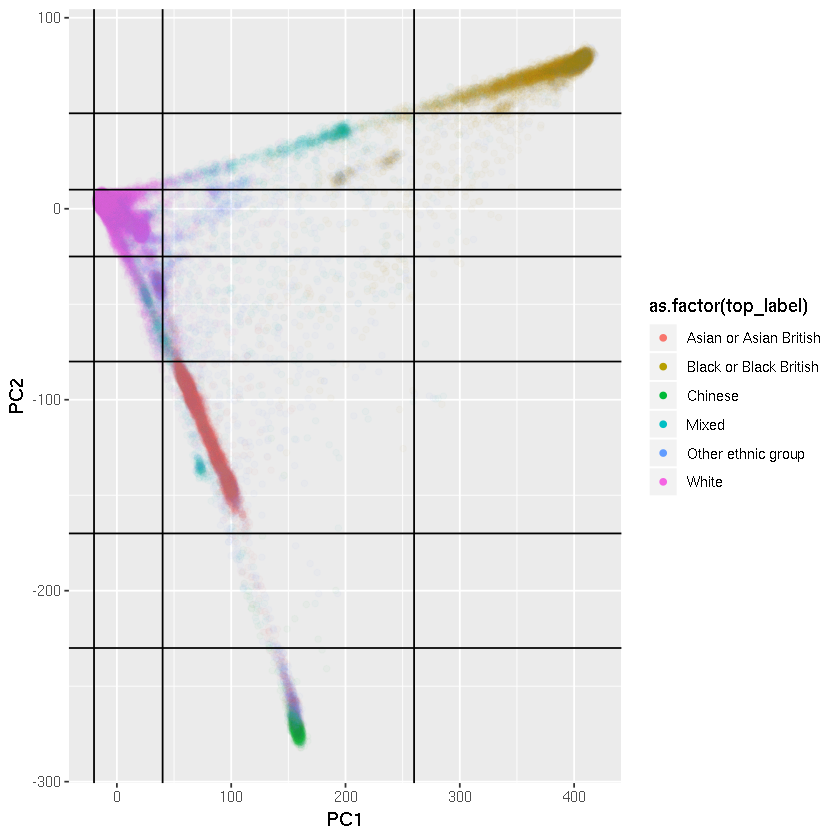

In [18]:
master_sqc_df %>% filter(pass_filter) %>% drop_na(f21000) %>%
filter(f21000 != -3, f21000 != -1) %>%
ggplot(aes(x = PC1, y = PC2, color=as.factor(top_label))) %>%
pca_plot_lines()


In [19]:
master_sqc_anno_df <- master_sqc_df %>% filter(pass_filter) %>% 
mutate(
    l_African  = if_else( 260 <= PC1 & 50  <= PC2, T, F),
    l_S_Asian  = if_else(-170 <= PC2 & PC2 <= -80, T, F),
    l_E_Asian  = if_else( PC2 <= -230,             T, F),
    l_European = if_else( -20 <= PC1 & PC1 <= 40 & -25 <= PC2 & PC2 <= 10,  T, F),
    l_NBW = if_else(l_European & l_self_reported_NBW, T, F),
    l_WB  = if_else(l_European & in_white_British_ancestry_subset, T, F)
)

### count the number of individuals in each of the five groups

In [20]:
master_sqc_anno_df %>% count(l_WB, l_NBW, l_African, l_S_Asian, l_E_Asian) %>% arrange(-n)

l_WB,l_NBW,l_African,l_S_Asian,l_E_Asian,n
TRUE,FALSE,FALSE,FALSE,FALSE,337151
FALSE,FALSE,FALSE,FALSE,FALSE,26045
FALSE,TRUE,FALSE,FALSE,FALSE,24909
FALSE,FALSE,FALSE,TRUE,FALSE,9084
FALSE,FALSE,TRUE,FALSE,FALSE,7214
FALSE,FALSE,FALSE,FALSE,TRUE,2356


### save the results to phe files

In [21]:
out_d <- '/oak/stanford/groups/mrivas/ukbb24983/sqc/population_stratification_w24983_20190804'

In [22]:
master_sqc_anno_df %>% filter(l_WB) %>%
select(FID, IID) %>% 
fwrite(file.path(out_d, 'ukb24983_white_british.phe'), sep='\t', col.names = F)

In [23]:
master_sqc_anno_df %>% filter(l_NBW) %>%
select(FID, IID) %>% 
fwrite(file.path(out_d, 'ukb24983_non_british_white'), sep='\t', col.names = F)

In [24]:
master_sqc_anno_df %>% filter(l_African) %>%
select(FID, IID) %>% 
fwrite(file.path(out_d, 'ukb24983_african.phe'), sep='\t', col.names = F)

In [25]:
master_sqc_anno_df %>% filter(l_S_Asian) %>%
select(FID, IID) %>% 
fwrite(file.path(out_d, 'ukb24983_s_asian.phe'), sep='\t', col.names = F)

In [26]:
master_sqc_anno_df %>% filter(l_E_Asian) %>%
select(FID, IID) %>% 
fwrite(file.path(out_d, 'ukb24983_e_asian.phe'), sep='\t', col.names = F)

### visualize the PCs

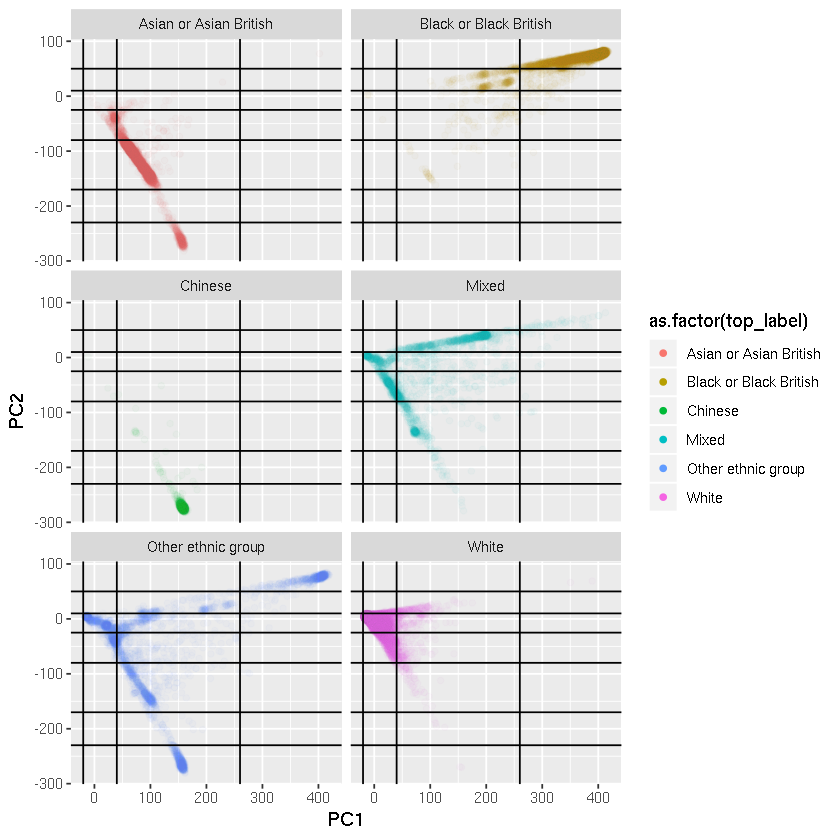

In [27]:
master_sqc_anno_df %>% drop_na(f21000) %>% filter(f21000 != -3, f21000 != -1) %>%
ggplot(aes(x = PC1, y = PC2, color=as.factor(top_label))) %>%
pca_plot_lines() + 
facet_wrap( ~ top_label, ncol=2) 

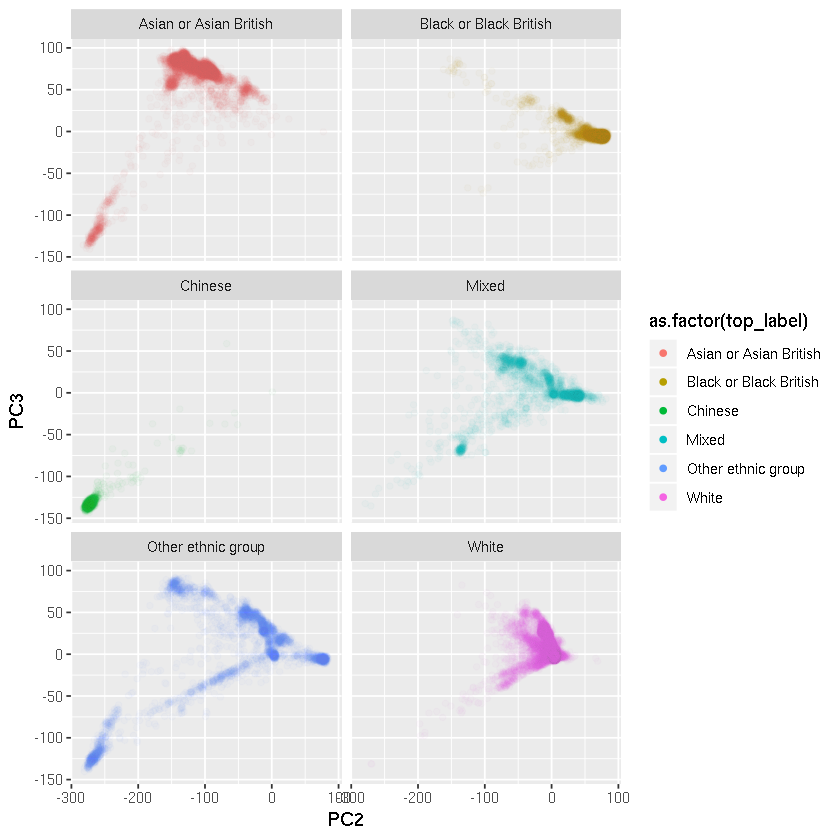

In [36]:
master_sqc_anno_df %>% drop_na(f21000) %>% filter(f21000 != -3, f21000 != -1) %>%
ggplot(aes(x = PC2, y = PC3, color=as.factor(top_label))) +
geom_point(alpha=.025) + 
guides(colour = guide_legend(override.aes = list(alpha = 1))) +
facet_wrap( ~ top_label, ncol=2) 

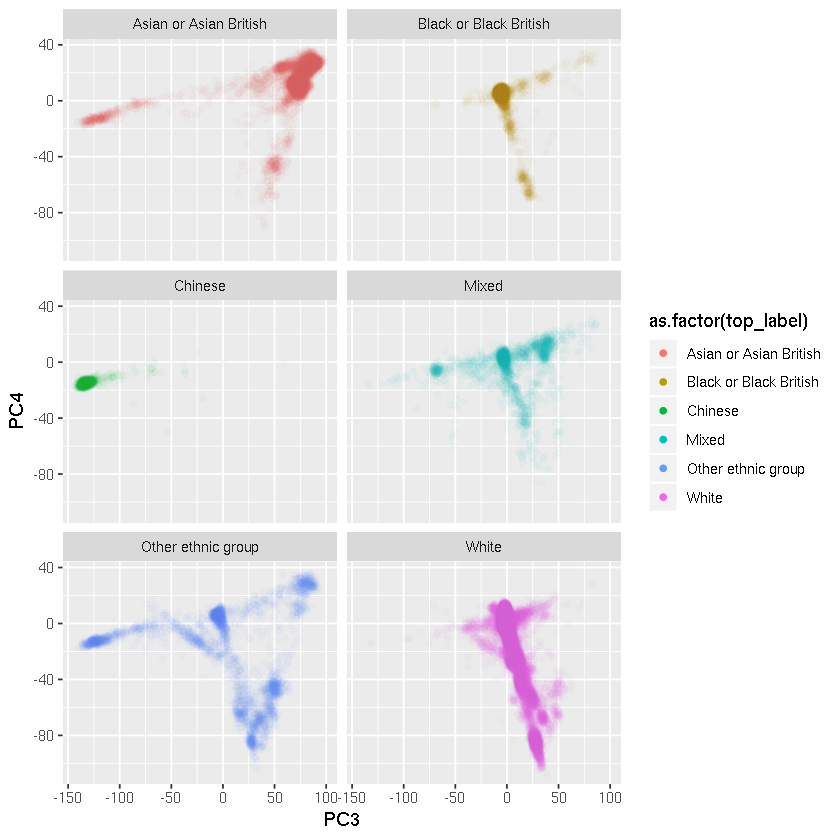

In [37]:
master_sqc_anno_df %>% drop_na(f21000) %>% filter(f21000 != -3, f21000 != -1) %>%
ggplot(aes(x = PC3, y = PC4, color=as.factor(top_label))) +
geom_point(alpha=.025) + 
guides(colour = guide_legend(override.aes = list(alpha = 1))) + 
facet_wrap( ~ top_label, ncol=2) 

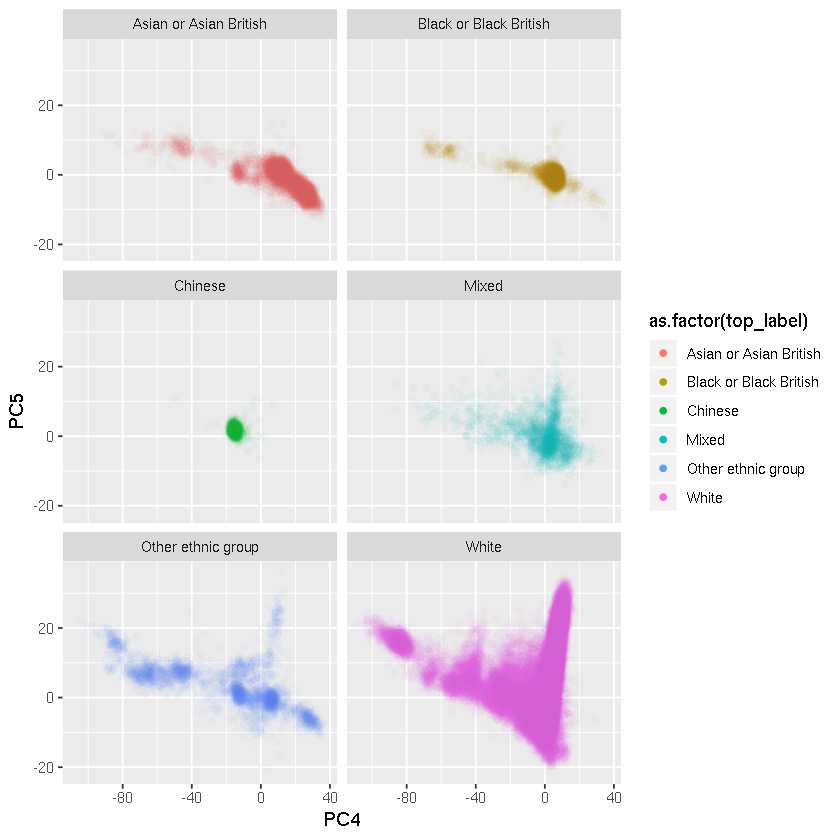

In [38]:
master_sqc_anno_df %>% drop_na(f21000) %>% filter(f21000 != -3, f21000 != -1) %>%
ggplot(aes(x = PC4, y = PC5, color=as.factor(top_label))) +
geom_point(alpha=.025) + 
guides(colour = guide_legend(override.aes = list(alpha = 1))) + 
facet_wrap( ~ top_label, ncol=2) 

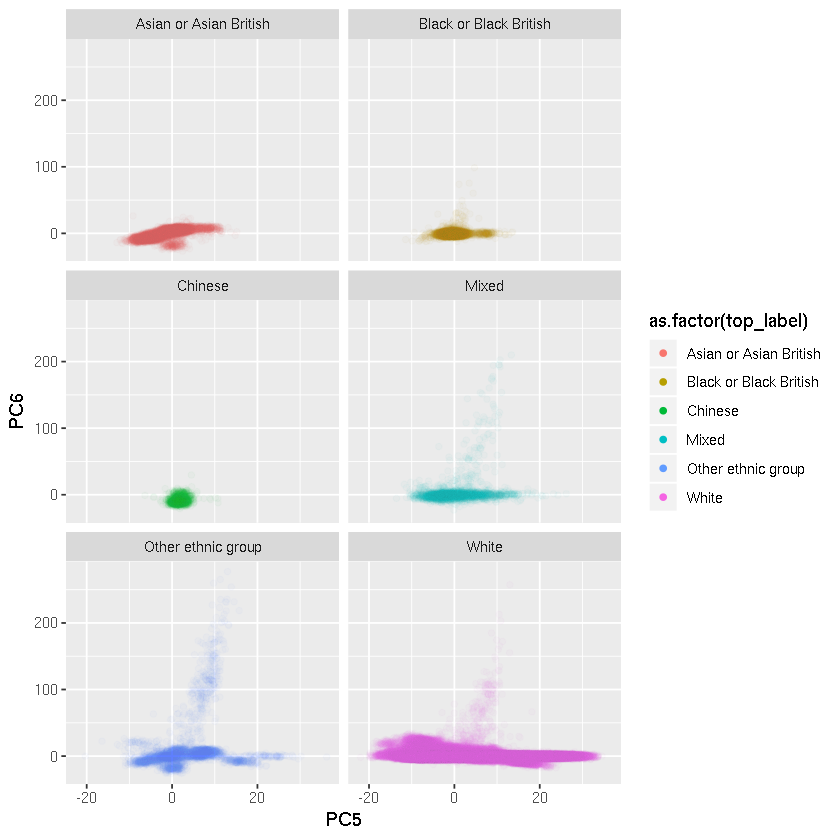

In [39]:
master_sqc_anno_df %>% drop_na(f21000) %>% filter(f21000 != -3, f21000 != -1) %>%
ggplot(aes(x = PC5, y = PC6, color=as.factor(top_label))) +
geom_point(alpha=.025) + 
guides(colour = guide_legend(override.aes = list(alpha = 1))) + 
facet_wrap( ~ top_label, ncol=2) 

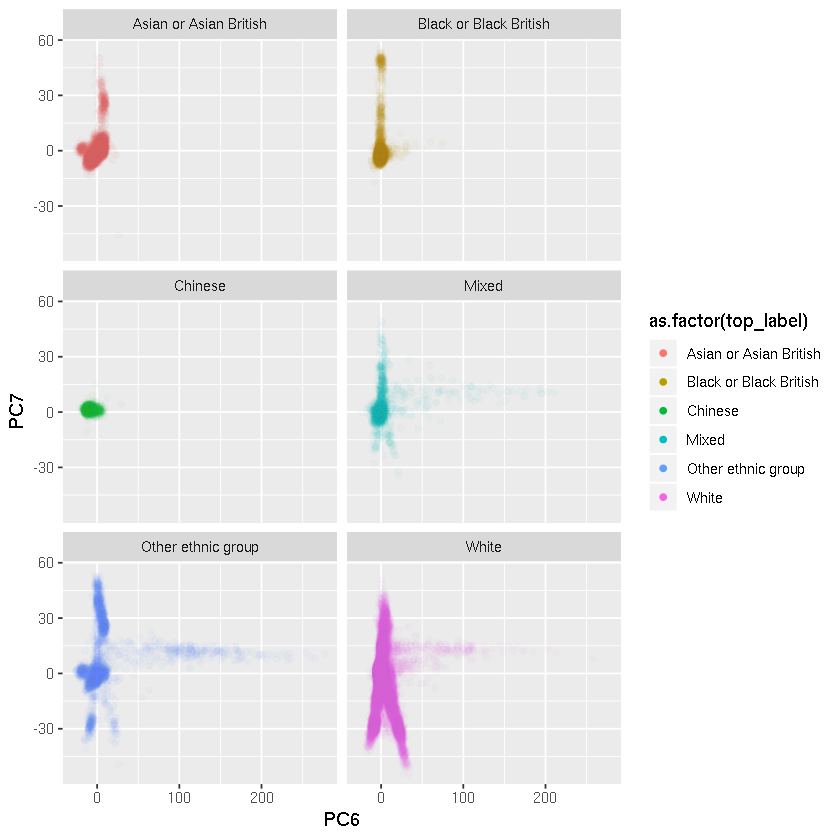

In [40]:
master_sqc_anno_df %>% drop_na(f21000) %>% filter(f21000 != -3, f21000 != -1) %>%
ggplot(aes(x = PC6, y = PC7, color=as.factor(top_label))) +
geom_point(alpha=.025) + 
guides(colour = guide_legend(override.aes = list(alpha = 1))) + 
facet_wrap( ~ top_label, ncol=2)

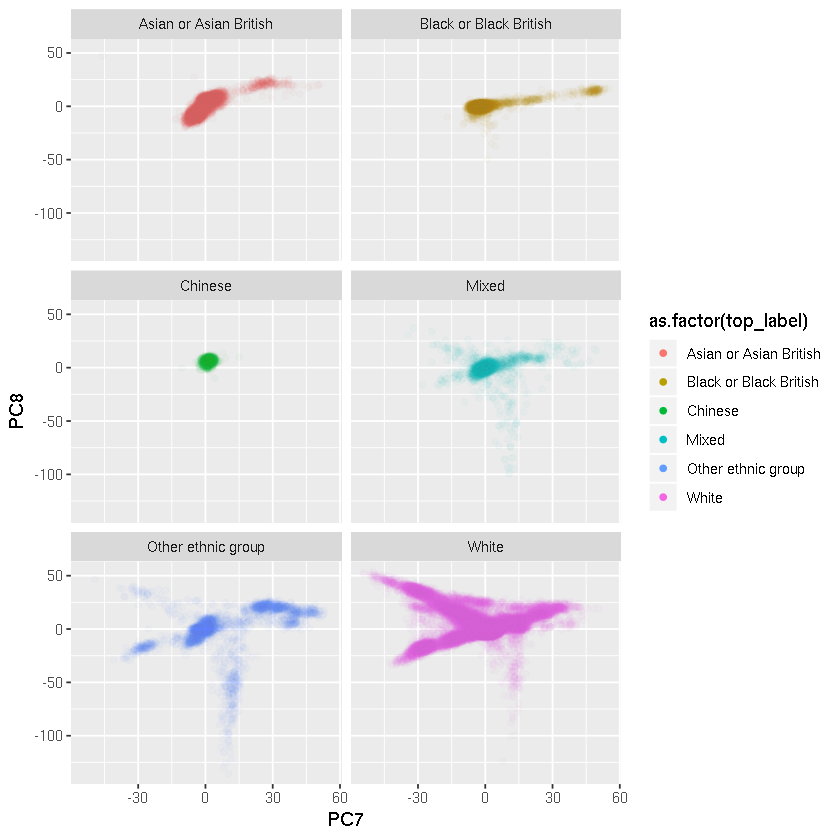

In [41]:
master_sqc_anno_df %>% drop_na(f21000) %>% filter(f21000 != -3, f21000 != -1) %>%
ggplot(aes(x = PC7, y = PC8, color=as.factor(top_label))) +
geom_point(alpha=.025) + 
guides(colour = guide_legend(override.aes = list(alpha = 1))) + 
facet_wrap( ~ top_label, ncol=2)

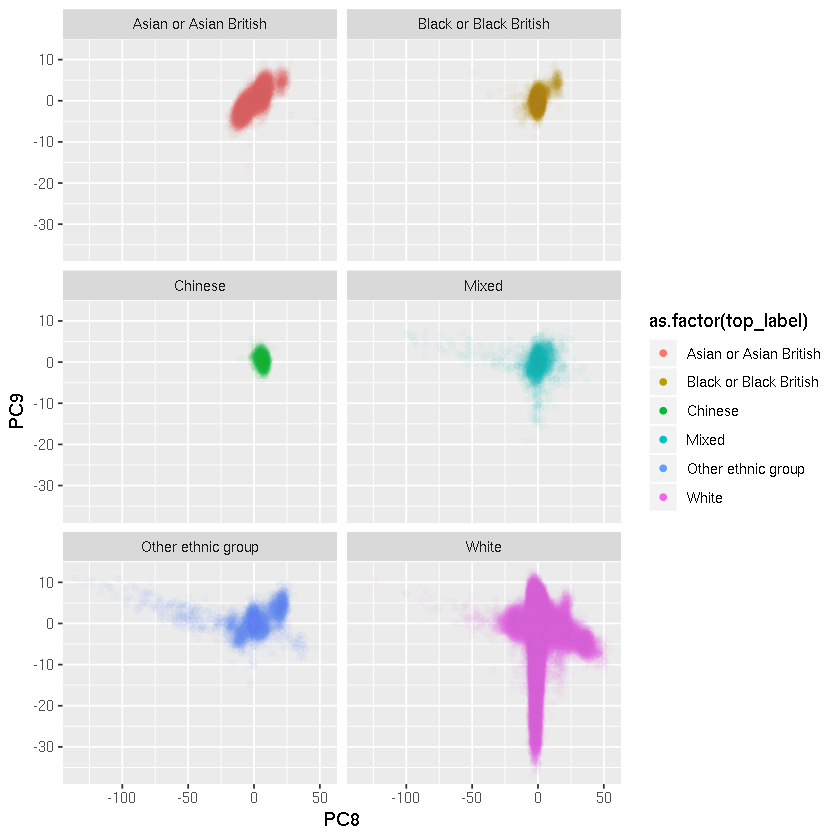

In [42]:
master_sqc_anno_df %>% drop_na(f21000) %>% filter(f21000 != -3, f21000 != -1) %>%
ggplot(aes(x = PC8, y = PC9, color=as.factor(top_label))) +
geom_point(alpha=.025) + 
guides(colour = guide_legend(override.aes = list(alpha = 1))) + 
facet_wrap( ~ top_label, ncol=2)

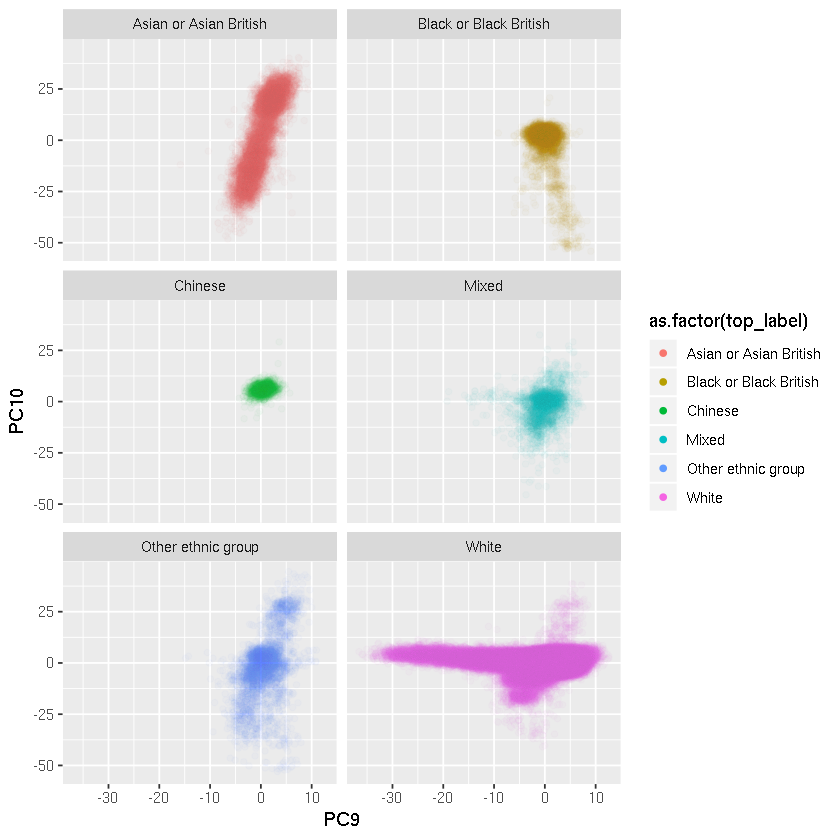

In [43]:
master_sqc_anno_df %>% drop_na(f21000) %>% filter(f21000 != -3, f21000 != -1) %>%
ggplot(aes(x = PC9, y = PC10, color=as.factor(top_label))) +
geom_point(alpha=.025) + 
guides(colour = guide_legend(override.aes = list(alpha = 1))) + 
facet_wrap( ~ top_label, ncol=2)